In [1]:
%run master_functions.ipynb

In [2]:
def plot_msd(hmm, ntrajper, res, traj_no, savename=None):
    
    final_p = get_params([hmm], hmm, hmm.z, clustered=False)

    traj = gen_realizations(final_p, ntrajper, progress=True)

    msd = individual_unclustered_realizations(res, traj_no, traj[np.newaxis, ...], single=True, savename=savename)

# Load Original IHMM File

In [5]:
res = 'ACH'

ihmm = file_rw.load_object('saved_parameters/2000iter_%s_unseeded.pl' % res)['ihmm']

# Define Trajectory that needs improvement and have a look

Found 9 unique states
[0.9923 0.9617 0.9733 0.89   0.4416 0.7274 0.3254 0.9996 0.9457]


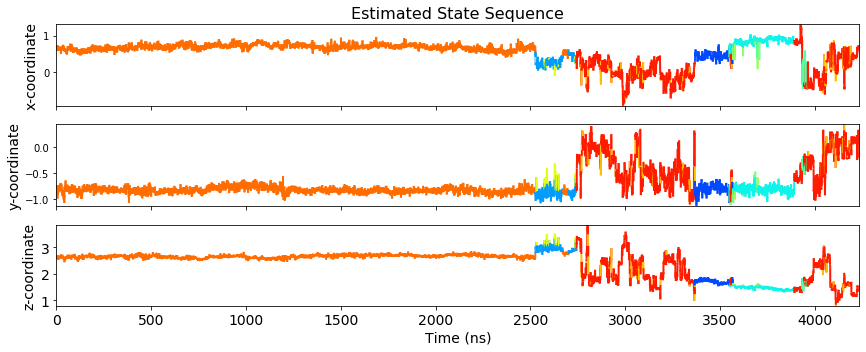

In [6]:
tr = 6  # trajectory number to improve
savename = '/home/ben/github/LLC_Membranes/Ben_Manuscripts/hdphmm/supporting_figures/state_sequence_before_%s_%d.pdf' % (res, tr)
ihmm[tr].summarize_results(savename=savename)

# Reparameterize Trajectory

These are parmeters that may need to be changed in order to get a better initial guess at the state sequence.
This will run the first 250 iterations of the IHMM procedure so that you can see if it's heading in the right direction.

Trajectory 6
Found 9 unique states
[0.9923 0.9617 0.9733 0.89   0.4416 0.7274 0.3254 0.9996 0.9457]


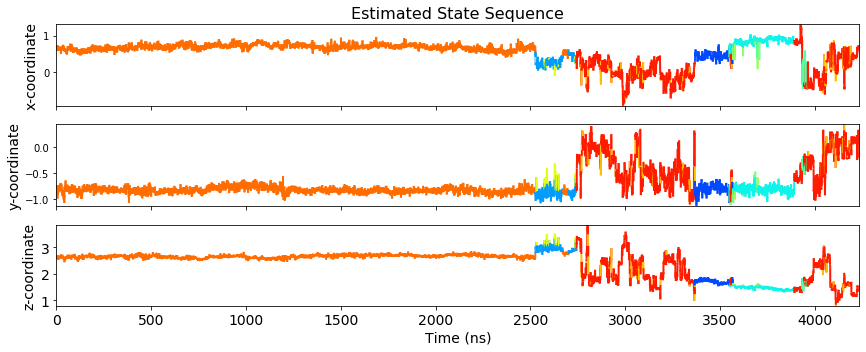

  0%|          | 0/5 [00:00<?, ?it/s]

Fitting 1 3 dimensional trajectories assuming an autoregressive order of 1
[0.1158 0.115  0.0974]
[ 0.694  -0.8457  2.6316]
Fitting 1 3 dimensional trajectories assuming an autoregressive order of 1
[0.1244 0.1173 0.0975]
[ 0.7157 -0.7963  2.6451]
Fitting 1 3 dimensional trajectories assuming an autoregressive order of 1
[0.4569 0.3693 0.6335]
[ 0.0021 -0.3419  2.5891]
Fitting 1 3 dimensional trajectories assuming an autoregressive order of 1
[0.5052 0.389  0.567 ]
[ 0.2976 -0.3503  1.9295]


  0%|          | 0/250 [00:00<?, ?it/s]

Seeding with 27 states
Fitting 1 3 dimensional trajectories assuming an autoregressive order of 1
[0.5549 0.389  0.7652]
[ 0.1981 -0.3503  2.3258]


100%|██████████| 250/250 [03:38<00:00,  1.15it/s]


Found 19 unique states
[0.9944 0.9971 0.9597 0.9768 0.9623 0.9575 0.912  0.9817 0.9882 0.9936
 0.9938 0.9578 0.9839 0.9923 0.989  0.94   0.9816 0.9656 0.8757]


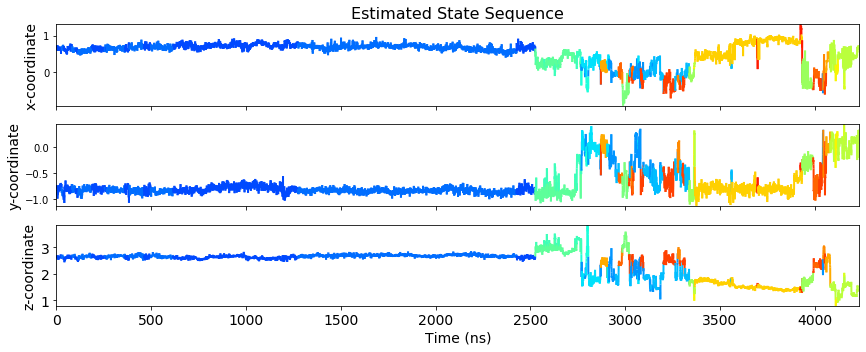

100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


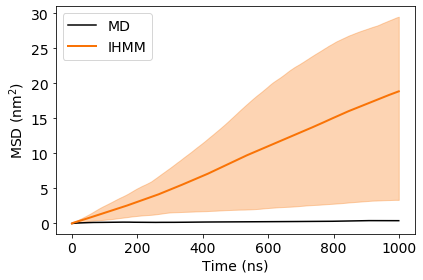

100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


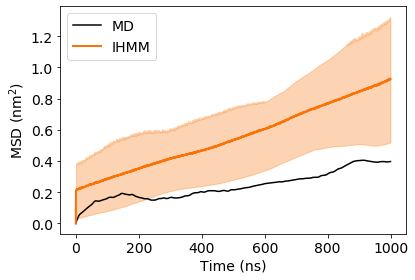

In [7]:
load = True  # should be False if reparameterizing
show_traj = True
save = False
mod_T = False
ntrajper = 10
analyze = [tr] # np.arange(24)#[14] #, 14, 15, 21]
seed = True
seed_segs = 4

# IHMM params
max_states = 100  # More is usually better
com = 'trajectories/com_xy_radial_%s.pl' % res
load_com=True
#hyperparams={'scale_sig0': np.array([1, 1]), 'a_gamma': 50}
hyperparams={'a_gamma': 5000}
hyperparams=None

com_filename = 'trajectories/com_xy_radial_%s.pl' % res

if seed:
    com = file_rw.load_object(com_filename)
    load_com = False
else:
    com = com_filename
    load_com = True

for i, hmm in enumerate(ihmm):
    
    if i in analyze:
        
        print('Trajectory %d' % i)

        if show_traj:

            hmm.summarize_results(traj_no=0)
            
        if seed:
            
            z = seed_sequence(com, i, nseg=seed_segs, max_states=max_states, niter=5)
            print('Seeding with %d states' % np.unique(z).size)
            com = (com[0][:(z.size + 1), ...], com[1])
            load_com = False
            
        else:
        
            z = None
            load_com = True
            
        # do it again
        new_hmm = hdphmm.InfiniteHMM(com, traj_no=i, load_com=load_com, difference=False, 
                             observation_model='AR', order=1, max_states=max_states,
                             dim=[0, 1, 2], prior='MNIW-N', save_every=20, hyperparams=hyperparams,
                             seed_sequence=z)
        
        new_hmm.inference(250)
        
        new_hmm.summarize_results(traj_no=0)
        new_hmm._get_params(traj_no=0)
        
        plot_msd(hmm, ntrajper, res, i)
        
        plot_msd(new_hmm, ntrajper, res, i)


# Look for convergence in the total number of states

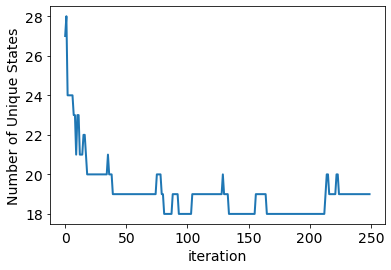

In [8]:
plt.plot(new_hmm.convergence['nstates'], lw=2)
plt.xlabel('iteration', fontsize=14)
plt.ylabel('Number of Unique States', fontsize=14)
plt.tick_params(labelsize=14)
plt.show()

# If satisfied with above, continue the remainder of IHMM procedure

In [9]:
new_hmm.inference(1750)  # I want 2000 total iterations for the paper

100%|██████████| 1750/1750 [24:57<00:00,  1.17it/s]


# Check that number of unique states stopped changing

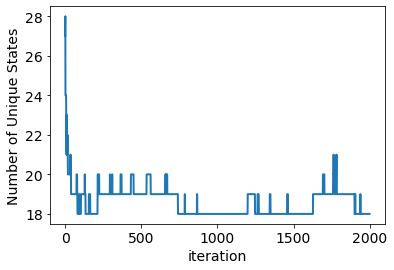

In [10]:
plt.plot(new_hmm.convergence['nstates'], lw=2)
plt.xlabel('iteration', fontsize=14)
plt.ylabel('Number of Unique States', fontsize=14)
plt.tick_params(labelsize=14)
plt.show()

# Get new converged parameters

In [11]:
new_hmm._get_params()  # need to do this to update the converged parameters

# View and/or save a picture of the new state sequence and MSD prediction

Found 18 unique states
[0.996  0.9979 0.9278 0.9537 0.9812 0.9146 0.9551 0.9804 0.9942 0.9837
 0.9819 0.9961 0.9496 0.9563 0.9572 0.975  0.9992 0.9264]


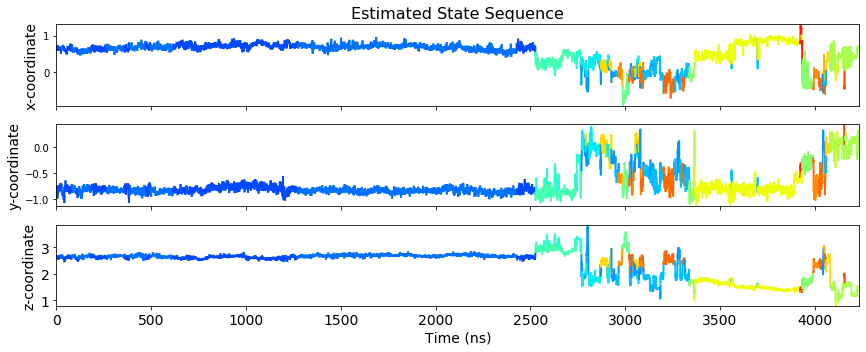

In [12]:
save = False

if save:
    savename = '/home/ben/github/LLC_Membranes/Ben_Manuscripts/hdphmm/supporting_figures/state_sequence_after_%s_%d.pdf' % (res, analyze[0])
else:
    savename = None
    
new_hmm.summarize_results(traj_no=0, savename=savename)

100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


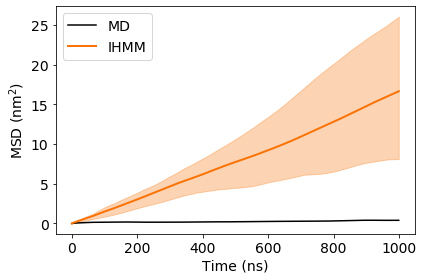

In [13]:
if save:
    savename = '/home/ben/github/LLC_Membranes/Ben_Manuscripts/hdphmm/supporting_figures/overestimate_%s_%d.pdf' % (res, analyze[0])
else:
    savename = None

plot_msd(ihmm[tr], ntrajper, res, tr, savename=savename)

100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


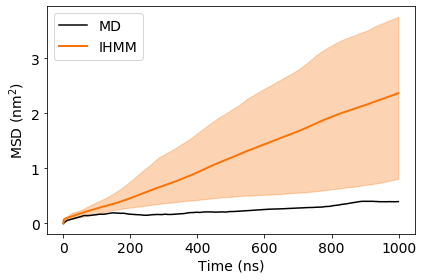

In [14]:
if save:
    savename = '/home/ben/github/LLC_Membranes/Ben_Manuscripts/hdphmm/supporting_figures/msd_improvement_%s_%d.pdf' % (res, analyze[0])
else:
    savename = None
    
plot_msd(new_hmm, ntrajper, res, tr, savename=savename)

# Update IHMM file with new parameterization

In [15]:
ihmm[tr] = new_hmm

In [16]:
file_rw.save_object({'ihmm': ihmm, 'ihmmr': None}, 'saved_parameters/2000iter_%s_unseeded.pl' % res)

# Test New IHMM file

In [17]:
ihmm2 = file_rw.load_object('saved_parameters/2000iter_%s_unseeded.pl' % res)['ihmm']

Found 18 unique states
[0.996  0.9979 0.9278 0.9537 0.9812 0.9146 0.9551 0.9804 0.9942 0.9837
 0.9819 0.9961 0.9496 0.9563 0.9572 0.975  0.9992 0.9264]


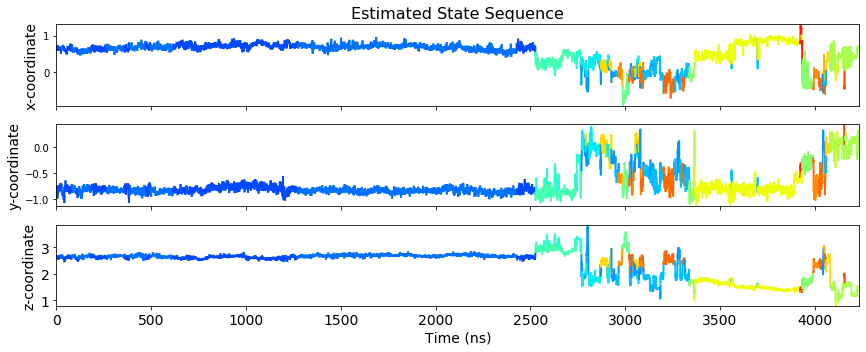

In [18]:
ihmm2[tr].summarize_results()

In [ ]:
plot_msd(ihmm2[tr], 10, res, tr)

# Visualize Seeded Initial Sequences

In [ ]:
save_prefix = '/home/ben/github/LLC_Membranes/Ben_Manuscripts/hdphmm/supporting_figures/seed_%s%d' %(res, tr)
z = seed_sequence(file_rw.load_object(com_filename), tr, nseg=4, max_states=100, niter=5, save_prefix=save_prefix)

In [ ]:
seeded = hdphmm.InfiniteHMM(com_filename, traj_no=tr, load_com=True, difference=False, 
                     observation_model='AR', order=1, max_states=max_states,
                     dim=[0, 1, 2], prior='MNIW-N', save_every=20, hyperparams=hyperparams,
                     seed_sequence=z)

seeded.inference(1)

In [ ]:
savename = '/home/ben/github/LLC_Membranes/Ben_Manuscripts/hdphmm/supporting_figures/seed_%s%d_full.pdf' %(res, tr)
seeded.summarize_results(savename=savename)